In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from numba import njit

In [64]:
def rolling_mutual(t_index, x, x_bins, num_days, num_days_gap, num_days_stride):
    result = []
    time_origin = num_days + num_days_gap
    while(True):
        reference_mask = t_index < time_origin - num_days_gap
        data_mask = (t_index < time_origin + num_days)*(t_index >= time_origin)
        if(data_mask.any()):
            hist_ref, edges_ref =  np.histogram(x[reference_mask], bins=x_bins, density=True)
            hist, edges =  np.histogram(x[data_mask], bins=x_bins, density=True)
            mutual = (-np.log(hist) + np.log(hist_ref))*hist_ref*np.diff(edges_ref)
            mutual[~np.isfinite(mutual)] = 0.0
            mutual = np.sum(mutual)
            result.append((time_origin,mutual ))
        else:
            break
        time_origin += num_days_stride
    return np.array(result)

In [58]:
catalog = pd.read_csv('quakes/japan.csv', low_memory=False)[['Time', 'Latitude', 'Longitude', 'Magnitude']]
catalog['Time'] = pd.to_datetime(catalog['Time'])
catalog = catalog.sort_values(by='Time').reset_index(drop=True)
catalog

,Time,Latitude,Longitude,Magnitude
0,1980-01-01 16:33:55+00:00,33.1500,142.3999,3.9
1,1980-01-01 20:33:51+00:00,24.1321,121.7013,4.0
2,1980-01-01 22:26:45+00:00,36.4540,140.6699,4.2
3,1980-01-03 07:26:34+00:00,20.0951,121.7679,4.6
4,1980-01-03 19:58:07+00:00,28.4799,128.4021,5.4
...,...,...,...,...
140341,2023-10-21 21:19:17+00:00,31.0347,138.2951,4.0
140342,2023-10-22 12:48:21+00:00,40.5636,141.9595,4.4
140343,2023-10-22 14:13:40+00:00,27.2115,128.2038,4.6
140344,2023-10-22 23:11:14+00:00,35.6948,140.8387,4.2


In [59]:
min_lon, max_lon = catalog['Longitude'].min(), catalog['Longitude'].max()
min_lat, max_lat = catalog['Latitude'].min(), catalog['Latitude'].max()
spacing = 6.0 #degrees
num_lons =ceil((max_lon-min_lon)/spacing)
num_lats =ceil((max_lat-min_lat)/spacing)
catalog['j'] = (num_lons*(catalog['Longitude']-min_lon)/(max_lon-min_lon)).astype('int')
catalog['i'] = (num_lats*(catalog['Latitude']-min_lat)/(max_lat-min_lat)).astype('int')
catalog['dt'] = catalog['Time']-catalog.iloc[0]['Time']
catalog['n'] = (catalog['dt']/np.timedelta64(1, 'D')).astype('int')
catalog

,Time,Latitude,Longitude,Magnitude,j,i,dt,n
0,1980-01-01 16:33:55+00:00,33.1500,142.3999,3.9,3,2,0 days 00:00:00,0
1,1980-01-01 20:33:51+00:00,24.1321,121.7013,4.0,0,0,0 days 03:59:56,0
2,1980-01-01 22:26:45+00:00,36.4540,140.6699,4.2,3,2,0 days 05:52:50,0
3,1980-01-03 07:26:34+00:00,20.0951,121.7679,4.6,0,0,1 days 14:52:39,1
4,1980-01-03 19:58:07+00:00,28.4799,128.4021,5.4,1,1,2 days 03:24:12,2
...,...,...,...,...,...,...,...,...
140341,2023-10-21 21:19:17+00:00,31.0347,138.2951,4.0,3,1,15999 days 04:45:22,15999
140342,2023-10-22 12:48:21+00:00,40.5636,141.9595,4.4,3,3,15999 days 20:14:26,15999
140343,2023-10-22 14:13:40+00:00,27.2115,128.2038,4.6,1,1,15999 days 21:39:45,15999
140344,2023-10-22 23:11:14+00:00,35.6948,140.8387,4.2,3,2,16000 days 06:37:19,16000


In [89]:
result = rolling_mutual(catalog['n'], catalog['Magnitude'], np.linspace(4, 8, 50), 30, 90, 1)

/var/folders/c9/zq2xv6cx5rs0m905bd49pklr0000gp/T/ipykernel_37470/1068007079.py:10: RuntimeWarning: divide by zero encountered in log
  mutual = (-np.log(hist) + np.log(hist_ref))*hist_ref*np.diff(edges_ref)
/var/folders/c9/zq2xv6cx5rs0m905bd49pklr0000gp/T/ipykernel_37470/1068007079.py:10: RuntimeWarning: invalid value encountered in add
  mutual = (-np.log(hist) + np.log(hist_ref))*hist_ref*np.diff(edges_ref)
/var/folders/c9/zq2xv6cx5rs0m905bd49pklr0000gp/T/ipykernel_37470/1068007079.py:10: RuntimeWarning: invalid value encountered in multiply
  mutual = (-np.log(hist) + np.log(hist_ref))*hist_ref*np.diff(edges_ref)


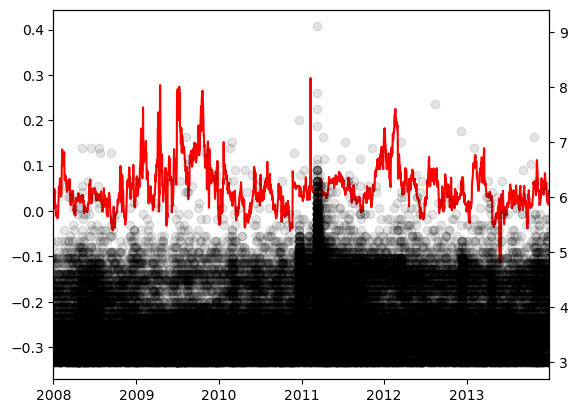

In [93]:
plt.plot( catalog.iloc[0]['Time'] + (result[:, 0]).astype('timedelta64[D]'), result[:, 1], c='red')
plt.xlim(np.datetime64('2008-01-01'), np.datetime64('2013-12-31'))
plt.gca().twinx().scatter(catalog['Time'],catalog['Magnitude'], alpha=0.1, color='black')

In [53]:
num_steps_lag = 365
for (lat_i, lon_j), group in catalog.groupby(['i','j']):
    print(len(group))
    rolling_mutual(group['n'], group['Magnitude'], np.linspace(2, 9, 50), 30, 30, 15)

46221
1348
12
4919
1975
338
6974
523
11707
324
276
723
4590
28560


/opt/anaconda3/envs/wings/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


1115
512
133
442
14502
8368
136
129
89
1868
4557
4
1
